# Biodiversity Intactness Index
#### Author: Brooke Grazda
#### [Link to Repository](https://github.com/bgrazda/eds220-final.git)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 
from IPython.display import Image  # To nicely display images
from geogif import gif
from shapely.geometry import box
import xarray as xr
import os
from pystac import Catalog, get_stac_version
import contextily as cx


## Import Data

In [2]:
# Import Biodiversity Intactness collection
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                     modifier=planetary_computer.sign_inplace)
collection = catalog.get_collection("io-biodiversity")
collection.title

'Biodiversity Intactness'

In [3]:
arizona_bound = gpd.read_file(os.path.join('data', 
                                          'tl_2020_04_cousub.shp'))

## Data Exploration

<Axes: >

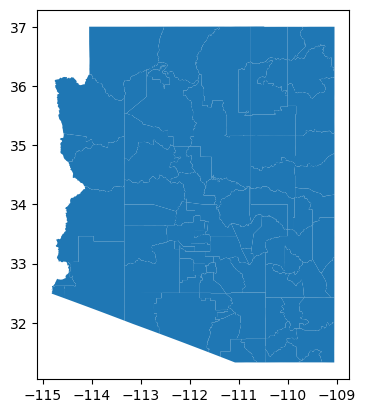

In [4]:
arizona_bound.plot()

In [5]:
arizona_bound.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,015,91964,02582914,0401591964,Lake Havasu City,Lake Havasu City CCD,22,Z5,G4040,None,None,None,S,7493863105,50863803,+34.7686221,-113.8749805,"POLYGON ((-114.48778 34.71722, -114.48622 34.7..."
1,04,007,91277,02582913,0400791277,Fort Apache,Fort Apache CCD,22,Z5,G4040,None,None,None,S,2134058292,4388167,+33.8847663,-110.3394452,"POLYGON ((-110.78327 34.16750, -110.78276 34.1..."
2,04,003,90306,01934923,0400390306,Bisbee,Bisbee CCD,22,Z5,G4040,None,None,None,S,1610943633,3494169,+31.4580397,-110.0783372,"POLYGON ((-110.46089 31.47376, -110.46089 31.4..."
3,04,003,90408,01934925,0400390408,Bowie,Bowie CCD,22,Z5,G4040,None,None,None,S,3556140749,1110460,+32.1699052,-109.3999964,"POLYGON ((-109.76866 32.30583, -109.76787 32.3..."
4,04,003,93825,01934992,0400393825,Willcox,Willcox CCD,22,Z5,G4040,None,None,None,S,1898081614,4959613,+32.1980984,-109.8877527,"POLYGON ((-110.15218 32.17203, -110.15213 32.1..."


In [6]:
# Get more informaiton about CRS
print('ellipsoid: ', arizona_bound.crs.ellipsoid)
print('datum: ', arizona_bound.crs.datum)
print('is geographic?', arizona_bound.crs.is_geographic)
print('is projected?', arizona_bound.crs.is_projected)

ellipsoid:  GRS 1980
datum:  North American Datum 1983
is geographic? True
is projected? False


In [7]:
collection

<CollectionClient id=io-biodiversity>

In [8]:
arizona_bound.dtypes

STATEFP       object
COUNTYFP      object
COUSUBFP      object
COUSUBNS      object
GEOID         object
NAME          object
NAMELSAD      object
LSAD          object
CLASSFP       object
MTFCC         object
CNECTAFP      object
NECTAFP       object
NCTADVFP      object
FUNCSTAT      object
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [9]:
arizona_bound.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

### Preliminary Observations

From the initial exploration of both datasets, I learned that the arizona county subdivisions geodataframe has a geographic CRS of GRS 1980. The datum is the North American Datum 9183. I also saw that the majority of the data types are string objects, except for the columns `ALAND` and `AWATER`, which were integers, and the geometries. I viewed the first 5 observations in the arizona geodataframe to ensure that the clipping was correct using the bbox coordinates.

The Biodiversity Intactness Index collection describes its maps to depict biodivrresity intacness over the years 2017 to 2020 with high spatial resolution. The current bounding box for the STAC collection is [-180, -90, 180, 90] so I will have to adjust the bounding box to match that of Arizona county subdivisions.

In [10]:
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

search = catalog.search(
collections = collection,
bbox = bbox)

search

In [11]:
items = search.item_collection()
len(items)

4

In [12]:
items = list(search.items())
for item in items:
    print(item)

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2019_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2018_34.74464974521749_-115.38597824385106_cog>
<Item id=bii_2017_34.74464974521749_-115.38597824385106_cog>


In [13]:
item = items[0]

In [14]:
for key in item.assets.keys():
    print(key, '--', item.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [15]:
bii_2020_item = items[0]
print(bii_2020_item.properties)
bii_2017_item = items[3]
print(bii_2017_item.properties)

{'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2020-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2020-01-01T00:00:00Z'}
{'datetime': None, 'proj:epsg': 4326, 'proj:shape': [7992, 7992], 'end_datetime': '2017-12-31T23:59:59Z', 'proj:transform': [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0], 'start_datetime': '2017-01-01T00:00:00Z'}


In [16]:
bii_2017 = rioxr.open_rasterio(bii_2017_item.assets['data'].href)
bii_2020 = rioxr.open_rasterio(bii_2020_item.assets['data'].href)

## Phoenix within broader geographic context

<Axes: >

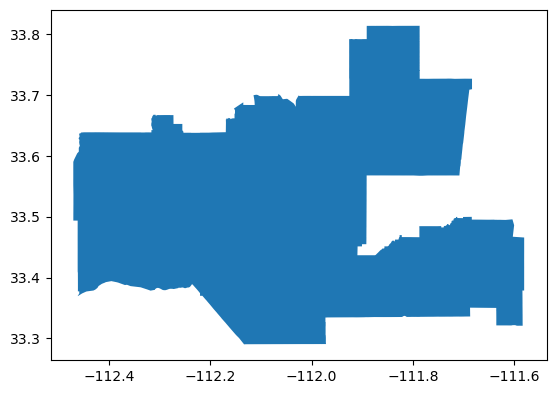

In [17]:
phoenix = arizona_bound[arizona_bound.NAME == 'Phoenix']

phoenix.plot()

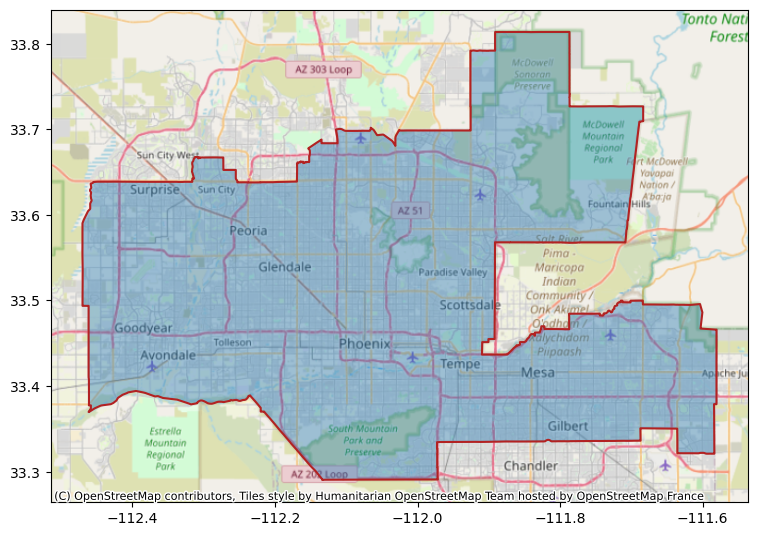

In [18]:
# Phoenix subdivision in broader geographic context
ax = phoenix.plot(figsize=(9,9), alpha = .4)


phoenix.boundary.plot(ax = ax, 
                     color = 'firebrick')
# Use contextily to show roads
cx.add_basemap(ax, crs = phoenix.crs)

In [19]:
# Original dimensions and coordinates
print(bii_2017.dims, bii_2017.coords,'\n')

# Remove band dimension of length 1
bii_2017 = bii_2017.squeeze()
print(bii_2017.dims, bii_2017.coords,'\n')

# Remove coordinates associated to band
bii_2017 = bii_2017.drop_vars('band')
print(bii_2017.dims, bii_2017.coords)

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
    band         int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 

('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0


In [20]:
# Transform phoenix CRS to match the raster CRS

phoenix = phoenix.to_crs('epsg:4326')

In [21]:
# Creat geodf bbox to clip the STAC
# Bounding box as geodataframe
box_df = gpd.GeoDataFrame(geometry=[box(*bbox)],
                 crs='epsg:4326') 

In [22]:
# Assign empty cells to nan
# bii_2017 = bii_2017.rio.write_nodata(np.nan)

if bii_2017.rio.crs is None:
    # Set the CRS explicitly (replace 'epsg:4326' with the correct CRS)
    bii_2017.rio.write_crs("epsg:4326", inplace=True)

print(bii_2017.rio.crs)
print(box_df.crs)
print(bii_2017.rio.bounds)
print(box_df.total_bounds)

bii_2017 = bii_2017.rio.clip(box_df.geometry, box_df.crs)

EPSG:4326
epsg:4326
<bound method XRasterBase.bounds of <rioxarray.raster_array.RasterArray object at 0x7fcaa6445a90>>
[-112.826843   32.974108 -111.184387   33.863574]


In [23]:
# Assign empty cells to nan
# bii_2020 = bii_2020.rio.write_nodata(np.nan)

# Debug 
if bii_2020.rio.crs is None:
    # Set the CRS explicitly (replace 'epsg:4326' with the correct CRS)
    bii_2020.rio.write_crs("epsg:4326", inplace=True)

print(bii_2020.rio.crs)
print(box_df.crs)
print(bii_2020.rio.bounds)
print(box_df.total_bounds)

bii_2020 = bii_2020.rio.clip(box_df.geometry, box_df.crs)

EPSG:4326
epsg:4326
<bound method XRasterBase.bounds of <rioxarray.raster_array.RasterArray object at 0x7fcaa63aa890>>
[-112.826843   32.974108 -111.184387   33.863574]


**List comprehension format reminder:** `[expression for item in items if condition]`

In [24]:
raster_data = bii_2017.values
total = np.sum(raster_data)
    valid_mask = ~np.isnan(raster_data)
mask_2017_bio = ras

SyntaxError: invalid syntax (321655340.py, line 1)

In [ ]:
# Add a base map using contextily

bii.plot.imshow(robust = True)
phoenix.plot(ax = ax)